<a href="https://colab.research.google.com/github/royal-dit/tensorflow-deeplearning/blob/main/bitcoin%20price%20prediction/btc_price_predictor_part_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
 import pandas as pd
 import numpy as np
 import matplotlib.pyplot as plt
 from sklearn.preprocessing import MinMaxScaler
 from tensorflow.keras.layers import Dense,Dropout,LSTM
 from tensorflow.keras.models import Sequential
 import requests
 import tensorflow as tf


In [59]:
! wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv


--2022-11-02 15:45:25--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.01s   

2022-11-02 15:45:25 (11.8 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’ saved [178509/178509]



In [60]:
df=pd.read_csv('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',parse_dates=['Date'],index_col=['Date'])
df.head(2)

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383


In [61]:
#only want closing price for each day
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns={'Closing Price (USD)':"Price"})
bitcoin_prices.head()


,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [62]:
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()
timesteps[:5],prices[:5]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000'], dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866]))

In [63]:
HORIZON = 1  #predict next day of bitcon
WINDOW_SIZE = 7


In [64]:
def get_labelled_window(x,horizon=HORIZON):
  return x[:,:-horizon],x[:,-horizon]

In [65]:
 #create a function to view numpy arrays as windows
 def make_windows(x,window_size = WINDOW_SIZE,horizon = HORIZON):
   """
   turns 1d array into 2d array of seq labbeled windows
   """
   windows_step = np.expand_dims(np.arange(window_size+horizon),axis=0)
   #create a 2d array of multiple windows
   window_indexes = windows_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)),axis = 0).T
  #  print(f"window indexes:\n{window_indexes,window_indexes.shape}")

   #index on the target array with 2d array of multiple windows steps
   windowed_array=x[window_indexes]
   print(windowed_array)

   #get the labeled windows
   windows,labels = get_labelled_window(windowed_array,horizon=horizon)
   return windows, labels



#model 4 CONV1D

In [66]:
#making forecast on the model
def make_preds(model,input_data):
   forecast = model.predict(input_data)
   return tf.squeeze(forecast) #return 1d array of prediction
   

In [67]:
def mean_absolute_scaled_error(y_true,y_pred):
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))
  mae_naive_no_season=tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1]))
  return mae/mae_naive_no_season

In [68]:
def evaluate_preds(y_true,y_pred):
  #make sure floar32 datatype
  y_true = tf.cast(y_true,dtype = tf.float32)
  y_pred = tf.cast(y_pred,dtype = tf.float32)

  #calcuate the various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true,y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true,y_pred)
  rmse =tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)
  mase=mean_absolute_scaled_error(y_true,y_pred)
  # if mae.ndim>0:
  #   mae = tf.reduce_mean(mae)
  #   mse = tf.reduce_mean(mse)
  #   rmse = tf.reduce_mean(rmse)
  #   mape = tf.reduce_mean(mape)
  #   mase = tf.reduce_mean(mase)
  return{"mae":mae.numpy(),
          "mse":mse.numpy(),
          "rmse": rmse.numpy(),
          "mape":mape.numpy(),
           "mase":mase.numpy() }

In [69]:
#make train/test splits
def make_train_test_splits(windows,labels,test_split=0.2):
   split_size = int(len(windows)*(1-test_split)) #this seperate data in 80 20 
   train_windows = windows[:split_size]
   train_labels = labels[:split_size] 
   test_windows = windows[split_size:]
   test_labels = labels[split_size:]

   return train_windows,test_windows,train_labels,test_labels


In [70]:
import os
def create_model_checkpoint(model_name,save_path="model_experiment"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path,model_name),verbose=0,save_best_only=True)
  



In [71]:
full_windows,full_labels =  make_windows(prices,window_size = WINDOW_SIZE,horizon=HORIZON)

[[  123.65499      125.455        108.58483    ...   120.65533
    121.795        123.033     ]
 [  125.455        108.58483      118.67466    ...   121.795
    123.033        124.049     ]
 [  108.58483      118.67466      121.33866    ...   123.033
    124.049        125.96116   ]
 ...
 [58788.20967893 58102.19142623 55715.54665129 ... 49764.1320816
  50032.69313676 47885.62525472]
 [58102.19142623 55715.54665129 56573.5554719  ... 50032.69313676
  47885.62525472 45604.61575361]
 [55715.54665129 56573.5554719  52147.82118698 ... 47885.62525472
  45604.61575361 43144.47129086]]


In [72]:
len(full_windows),len(full_labels)

(2780, 2780)

In [73]:
#create train amd test sets
train_windows,test_windows,train_labels,test_labels = make_train_test_splits(full_windows,
                                                                             full_labels)

In [74]:
len(train_windows),len(train_labels) ,len(test_windows)

(2224, 2224, 556)

to use the conv1d layer we need an input shape of (batch_size,timesteps,input_dim)

In [75]:
train_windows[0].shape  #returns windows size

(7,)

In [76]:
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [77]:
expand_dims_layer = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=1))

In [78]:
print(f'original shape:{x.shape}')
print(f"expanded shape:{expand_dims_layer(x).shape}")
print(f"expanded shape:{expand_dims_layer(x)}")



original shape:(7,)
expanded shape:(7, 1)
expanded shape:[[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [ ]:
tf.random.set_seed(42)
#create conv1D model
model_4 = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=1)),
    tf.keras.layers.Conv1D(filters=128,kernel_size = 5,strides = 1,padding ="causal",activation='relu'),
    tf.keras.layers.Dense(1)
],name="model_4_conv1d")
model_4.compile(loss='mae',
                optimizer = 'adam'
                )
model_4.fit(train_windows,
            train_labels,
            batch_size = 128,
            epochs = 100,
            verbose = 1,
            validation_data = (test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)]
            )

In [80]:
model_4.summary()

Model: "model_4_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_9 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [81]:
model_4.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 17640.2461


17640.24609375

In [82]:
model_4 = tf.keras.models.load_model("model_experiment/model_4_conv1d")
model_4.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 15062.4346


15062.4345703125

In [83]:
model_4_preds = make_preds(model_4,input_data=test_windows)


18/18 [==============================] - 0s 1ms/step


In [84]:
model_4_preds.shape

TensorShape([556])

In [85]:
model_4_results = evaluate_preds(y_true = test_labels,y_pred = model_4_preds)
model_4_results

{'mae': 15062.435,
 'mse': 399805250.0,
 'rmse': 19995.13,
 'mape': 74.8581,
 'mase': 26.460526}

#model 5  RNN LSTM

In [86]:
tf.random.set_seed(42)
#lets build a functional API
inputs = tf.keras.layers.Input(shape=(WINDOW_SIZE))
x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=1))(inputs)
# x = tf.keras.layers.LSTM(128,return_sequences=True)
x = tf.keras.layers.LSTM(128,activation='relu')(x)
# x = tf.keras.layers.Dense(32,activation='relu')
output = tf.keras.layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs = inputs,outputs = output,name = "model_5_lstm")

In [ ]:
model_5.compile(loss='mae',
                optimizer = tf.keras.optimizers.Adam()
                )
model_5.fit(train_windows,
            train_labels,
            epochs = 100,
            batch_size = 128,
            validation_data = (test_windows,test_labels),
            callbacks = [create_model_checkpoint(model_name=model_5.name)]
            )

In [88]:
#load the best version of the model
model_5 = tf.keras.models.load_model("model_experiment/model_5_lstm")
model_5.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 592.9673


592.9673461914062

In [89]:
model_5_preds = make_preds(model_5,test_windows)


18/18 [==============================] - 0s 3ms/step


In [90]:
model_5_results = evaluate_preds(test_labels,model_5_preds)
model_5_results

{'mae': 592.96735,
 'mse': 1248880.5,
 'rmse': 1117.5332,
 'mape': 2.6613557,
 'mase': 1.0416794}

#model_6 Multivariate Data

In [93]:
bitcoin_prices.head(2)

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500


In [97]:
#lest add the bitcoin halving events on our dataset
block_reward_1 = 50    #january 2009
block_reward_2 = 25    # november 2012
block_reward_3 = 12.5 #9th july 2016
block_reward_4 = 6.25   #18th may 2020

#block reward dates 
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")



In [98]:
#create date ranges of where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days,block_reward_3_days


(1012, 2421)

In [106]:
#add in a block_reward_column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

#add in block reward values as a feature to out dataframe
bitcoin_prices_block.iloc[:block_reward_2_days,-1]=block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days,-1]=block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:,-1]=block_reward_4


In [107]:
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25
2021-05-17,45604.615754,6.25
2021-05-18,43144.471291,6.25


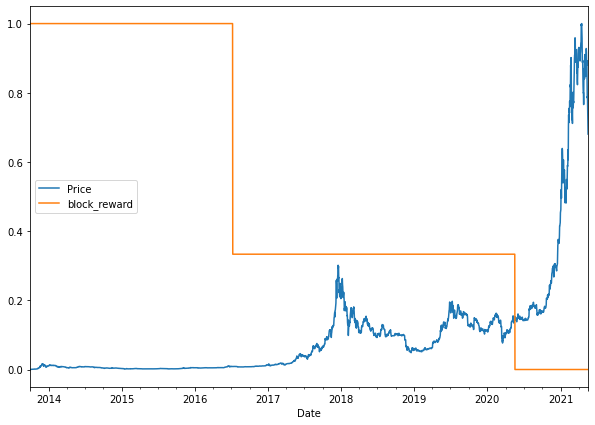

In [113]:
#pot the block reward vs price over time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price","block_reward"]]),
                                                  columns = bitcoin_prices_block.columns,
                                                  index = bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize = (10,7))


In [114]:
#making a windowed dataset with pandas with shift method
HORIZON = 1
WINDOW_SIZE=7



In [115]:
#make a copy of the bitcoin historical data with the block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()
#add windowed columns 
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,price+1,price+2,price+3,price+4,price+5,price+6,price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [116]:
X = bitcoin_prices_windowed.dropna().drop("Price",axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,price+1,price+2,price+3,price+4,price+5,price+6,price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [117]:
y.head

<bound method NDFrame.head of Date
2013-10-08      123.032997
2013-10-09      124.049004
2013-10-10      125.961159
2013-10-11      125.279663
2013-10-12      125.927498
                  ...     
2021-05-14    49764.132812
2021-05-15    50032.691406
2021-05-16    47885.625000
2021-05-17    45604.617188
2021-05-18    43144.472656
Name: Price, Length: 2780, dtype: float32>

In [121]:
#make a train and test split
split_size = int(len(X)*0.8)
X_train,y_train = X[:split_size],y[:split_size]
X_test,y_test = X[split_size:],y[split_size:]
len(X_train),len(y_train)

(2224, 2224)

In [128]:
tf.random.set_seed(42)
model_6 = tf.keras.Sequential([
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(1)
],name="model_6_dense_multivariate")

model_6.compile(loss='mae',
                optimizer='adam',
                metrics=['mae'])




In [ ]:
history = model_6.fit(X_train,
                      y_train,
                      epochs=100,
                      batch_size = 128,
                      validation_data = (X_test,y_test),
                      callbacks= [create_model_checkpoint(model_name=model_6.name)])


In [131]:
model_6.evaluate(X_test,y_test)


18/18 [==============================] - 0s 2ms/step - loss: 678.8438 - mae: 678.8438


[678.84375, 678.84375]

In [133]:
#load best performaing model
model_6 = tf.keras.models.load_model("model_experiment/model_6_dense")
model_6.evaluate(X_test,y_test)

18/18 [==============================] - 0s 3ms/step - loss: 567.8279 - mae: 567.8279


[567.827880859375, 567.827880859375]

In [135]:
model_6_preds = tf.squeeze(model_6.predict(X_test))

model_6_preds[:5]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8844.084, 8769.791, 9048.283, 8748.914, 8731.422], dtype=float32)>

In [136]:
model_6_results = evaluate_preds(y_true = y_test,y_pred=model_6_preds)

In [137]:
model_6_results

{'mae': 567.8279,
 'mse': 1163726.2,
 'rmse': 1078.7615,
 'mape': 2.546001,
 'mase': 0.99751633}